>[Prepration](#scrollTo=w6fVMDU2P5Y6)

>[Reading Twins and data prepration](#scrollTo=Da6fxkE6QHDP)

>[Make noisy label and Gestate10](#scrollTo=_Vg8taGE7h6j)

>[FCEVAE](#scrollTo=R28V46gVjQ6f)

>[Youssef Fuzzification](#scrollTo=dTENZFfQEIkR)

>[Colab codes snippes](#scrollTo=XZM6pAnMNYAe)

>[Test](#scrollTo=YXHMi-xpVkQt)



#Prepration

In [ ]:
!pip install causalml

In [1]:
!pip install -U scikit-fuzzy
!git clone https://github.com/cyrus1123/FCEVAET.git
%cd FCEVAET
!unzip pyro-dev.zip
%cd pyro-dev
!python setup.py install
import pyro
import math
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.util import torch_item
from pyro.nn import PyroModule
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan
!git clone https://github.com/cyrus1123/fuzz.git
%cd fuzz
!unzip Causal-probabilistic-fuzzy-logic-main.zip
%cd Causal-probabilistic-fuzzy-logic-main
import pandas as pd
from source.utils import Score
from source.Fuzzy import Fuzzy
from sklearn.model_selection import train_test_split

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import tensorflow as tf
from __future__ import absolute_import, division, print_function
import sys
import matplotlib.pyplot as plt
import logging
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)

import pandas as pd
import numpy as np
!git clone https://github.com/AMLab-Amsterdam/CEVAE.git
%cd CEVAE/datasets/TWINS    

     |████████████████████████████████| 1.0MB 5.9MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894069 sha256=a7551766e36704fb29241bd45118e0633aba0a3d0f22896018b0171c1885bd9a
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy
Cloning into 'FCEVAET'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
/content/FCEVAET
Archive:  pyro-dev.zip
   creating: pyro-dev/
  inflating: pyro-dev/.codecov.yml   
  inflating: pyro-dev/.coveragerc    
  inflating: pyro-dev/.gitattributes  
   creating: pyro-dev/.github/
  inflating: pyro-dev/.github/issue_template.md  
  inflating: pyro-dev/.gitignore     
  inflating: pyro-dev/.readthedocs.yml  
  inflating: pyro-dev/.travis.yml    
  inflating: 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Cloning into 'CEVAE'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72 (delta 0), reused 1 (delta 0), pack-reused 69
Unpacking objects: 100% (72/72), done.
/content/FCEVAET/pyro-dev/fuzz/Causal-probabilistic-fuzzy-logic-main/CEVAE/datasets/TWINS


# Reading Twins and data prepration

In [2]:
y=pd.read_csv('twin_pairs_Y_3years_samesex.csv', delimiter=',')
y=y.drop('Unnamed: 0', axis=1)
cols=['ya', 'yb']
y.columns=cols
Y=y.copy()
  

#Dataset cleaning and seperation according to infant sex.
x=pd.read_csv('twin_pairs_X_3years_samesex.csv', delimiter=',')
x_boy=x.copy()
x_boy=x_boy[x_boy['csex']==1]
x_girl=x.copy()
x_girl=x_girl[x_girl['csex']==0]
x_boy=x_boy.drop(['Unnamed: 0',	'Unnamed: 0.1'], axis=1 )
cols=[]
for i in range(52):
  cols.append('x{}'.format(i))
# x_boy.columns=cols
X_boy=x_boy.copy()  
# 
X_girl=x_girl.drop(['Unnamed: 0',	'Unnamed: 0.1'], axis=1 )
X_girl.columns=cols
X_girl=x_girl.copy() 


#Mortality rate of same sex twins
a0=np.sum(np.transpose(Y.iloc[X_girl.index].values)[0])/x.shape[0]
a1=np.sum(np.transpose(Y.iloc[X_girl.index].values)[1])/x.shape[0]
a2=np.sum(np.transpose(Y.iloc[X_boy.index].values)[0])/x.shape[0]
a3=np.sum(np.transpose(Y.iloc[X_boy.index].values)[1])/x.shape[0]
print((a0+a1+a2+a3)/2)


T=pd.read_csv('twin_pairs_T_3years_samesex.csv', delimiter=',')
T=T.drop('Unnamed: 0', axis=1)
cols=['T_0', 'T_1' ]
T.columns=cols
# The twins such that both were born weighing less than 2 Kg.
X_boy_less_than_2Kg = X_boy.copy()
X_girl_less_than_2Kg = X_girl.copy()
X_boy_less_than_2Kg = X_boy_less_than_2Kg[(T['T_0']<2000) & (T['T_1']<2000)]
X_girl_less_than_2Kg = X_girl_less_than_2Kg[(T['T_0']<2000) & (T['T_1']<2000)]
X_boy_less_than_2Kg = X_boy_less_than_2Kg.reset_index()
X_boy_less_than_2Kg = X_boy_less_than_2Kg.drop('index', axis=1)
X_girl_less_than_2Kg = X_boy_less_than_2Kg.reset_index()
X_girl_less_than_2Kg = X_girl_less_than_2Kg.drop('index', axis=1)
T[T['T_0']>=2500]=1
T[T['T_1']<2500]=0
Treatment=T.copy()


T=pd.read_csv('twin_pairs_T_3years_samesex.csv', delimiter=',')
T=T.drop('Unnamed: 0', axis=1)
cols=['T_0', 'T_1' ]
T.columns=cols
print(np.sum(np.transpose(Y.iloc[T[(T['T_0']<2000) & (T['T_1']<2000)].index].values)[0])/x.shape[0])

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


0.03591001471721915
0.031817226154600885


In [3]:
tr=np.sum(np.transpose(Y.iloc[T[(T['T_0']<2000) & (T['T_1']<2000)].index].values)[0])
tr1=np.sum(np.transpose(Y.iloc[T[(T['T_0']<2000) & (T['T_1']<2000)].index].values)[1])
(tr+tr1)/Y.shape[0]

0.05940149975471301

In [4]:
print(tr1/11984)
print(tr/11984)

0.16421895861148197
0.1894192256341789


In [5]:
Y.shape[0]

71345

In [6]:
# Outcome shape of twins weighing less than 2000g
Y_under_2000=Y.iloc[T[(T['T_0']<2000) & (T['T_1']<2000)]['T_0']]
Y_under_2000.shape
# Outcome shape of twins weighing more than 2000g
Y_over_2000=Y.iloc[T[(T['T_0']>=2000) & (T['T_1']>=2000)]['T_0']]
Y_over_2000.shape

(51560, 2)

In [7]:
# Treatment shape of twins weighing less than 2000g
T_under_2000=T[(T['T_0']<2000) & (T['T_1']<2000)]
T_under_2000.shape

(11984, 2)

In [8]:
(T_under_2000.sum(axis=0)[0]+ T_under_2000.sum(axis=0)[1])/(T.sum(axis=0)[0]+ T.sum(axis=0)[1])

0.09371557194309595

In [9]:
T_under_1000=T[(T['T_0']<1000) & (T['T_1']<1000)]

In [10]:
sum(np.transpose(y.iloc[T_under_1000.index].values)[0])/T_under_2000.shape[0]

0.13701602136181576

In [11]:
y

,ya,yb
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
71340,0.0,0.0
71341,0.0,0.0
71342,0.0,0.0
71343,0.0,0.0


In [12]:
#The mortality rate for the lighter twin is
np.sum(np.transpose(Y_under_2000.values)[1])/np.sum(np.transpose(Y.values)[1])

0.23483535528596186

In [13]:
A=np.sum(np.transpose(Y_under_2000.values)[0])/(np.sum(np.transpose(Y.values)[1])+np.sum(np.transpose(Y.values)[0]))
B=np.sum(np.transpose(Y_under_2000.values)[1])/(np.sum(np.transpose(Y.values)[1])+np.sum(np.transpose(Y.values)[0]))
(A+B)/2

0.11055815768930524

# Make noisy label and Gestate10

In [14]:
from pyro.distributions import Bernoulli
from pyro.distributions import Normal
from pyro.distributions import MultivariateNormal

In [15]:
def one_hot_encoder(x):
  temp=np.zeros((x.shape[0], 10))
  for i in range(x.shape[0]):
    temp[i][x[i]-1]=1
  return np.hstack((temp, temp, temp))
  
xz1=x.copy()
xz1=x['gestat10'].values
Z_coded = one_hot_encoder(xz1.reshape(xz1.shape[0]))

In [16]:
Z_coded.shape

(71345, 30)

In [17]:
Xm=x.copy()
Xm=Xm[(T['T_0']<2000) & (T['T_1']<2000)]
Xm=Xm.dropna()
Xmz=Xm.drop(['Unnamed: 0', 'Unnamed: 0.1', 'infant_id_0','infant_id_1'], axis=1)
Xm=Xm.drop(['Unnamed: 0', 'Unnamed: 0.1', 'infant_id_0','infant_id_1', 'gestat10'], axis=1)
cols=[]
for i in range(Xm.shape[1]):
  cols.append(i)
Xm.columns=cols  

def sigmoid(x):
  return 1/(1 + np.exp(-x))

z=np.array(Xmz['gestat10'])
z_encoded=one_hot_encoder(z)
def treatment_gen(i):
  W0=Normal(0 * torch.ones((1, 49)), torch.ones((1, 49))*0.1).sample()
  W0x=np.matmul(np.array(W0), Xm.iloc[i] )
  Wh=np.array(Normal(5, 0.1).sample())
  return sigmoid(W0x + Wh*((z[i]/10)-1))  

Treatment=[treatment_gen(i) for i in range(4821)]
Treatment=np.array(Bernoulli(torch.Tensor(Treatment)).sample())  

# Y prepration
YR=y.iloc[Xm.index]
YR=YR.reset_index()
YR=YR.drop('index', axis=1)
YR.columns=['y_factual' , 'y_cfactual']
#Concatenation
Treatment1=pd.DataFrame(Treatment)
Treatment1=Treatment1.reset_index()
Treatment1=Treatment1.drop('index', axis=1)
Treatment1.columns=['treatment']
Xm1=Xm.reset_index()
Xm1=Xm1.drop('index', axis=1)
cols=[]
for i in range(Xm1.shape[1]):
  cols.append(i)
Xm1.columns=cols  

Z_encoded=pd.DataFrame(z_encoded)
cols=[]
for i in range(49, Z_encoded.shape[1]+49):
  cols.append(i)
Z_encoded.columns=cols  
Twins=pd.concat([Treatment1, YR, Xm1, Z_encoded], axis=1)


In [18]:
Twins1= pd.concat([Twins, Twins, Twins, Twins, Twins, Twins, Twins, Twins, Twins, Twins], axis=0)
Twins1= Twins1.reset_index()
Twins1= Twins1.drop('index' ,axis=1)
Twins1.shape

(48210, 82)

In [19]:
Twins1.columns

Index([ 'treatment',  'y_factual', 'y_cfactual',            0,            1,
                  2,            3,            4,            5,            6,
                  7,            8,            9,           10,           11,
                 12,           13,           14,           15,           16,
                 17,           18,           19,           20,           21,
                 22,           23,           24,           25,           26,
                 27,           28,           29,           30,           31,
                 32,           33,           34,           35,           36,
                 37,           38,           39,           40,           41,
                 42,           43,           44,           45,           46,
                 47,           48,           49,           50,           51,
                 52,           53,           54,           55,           56,
                 57,           58,           59,           60,           61,

In [20]:
def noise(x, p):
  var0=0
  var1=(1-(pyro.sample('make_noise', pyro.distributions.Bernoulli(p))))
  if x==0 and var1==1:
    var0=1
  if x==1 and var1==1:
    var0=0
  if var1==0:
    var0=x
  return var0


Noise=np.vectorize(noise)  
 

def w0(a):
  return pyro.sample("my_sample", pyro.distributions.Normal(0, 0.1))
W0=np.vectorize(w0)  


def sigmoid(x):
  return 1/(1 + np.exp(-x))

In [21]:
T1=Twins1[Twins1['treatment']==1]
T0=Twins1[Twins1['treatment']==0]
np.mean(T1['y_factual'])-np.mean(T0['y_factual'])

-0.02299328590039082

#Dowhy Twins

In [ ]:
!pip install dowhy
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from dowhy import causal_estimators

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [ ]:
#The covariates data has 46 features
x = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_X_3years_samesex.csv")

#The outcome data contains mortality of the lighter and heavier twin
y = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_Y_3years_samesex.csv")

#The treatment data contains weight in grams of both the twins
t = pd.read_csv("https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/TWINS/twin_pairs_T_3years_samesex.csv")

In [ ]:
#_0 denotes features specific to the lighter twin and _1 denotes features specific to the heavier twin
lighter_columns = ['pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6', 'infant_id_0',
       'dlivord_min', 'dtotord_min', 'bord_0',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']
heavier_columns = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id_1', 'dlivord_min', 'dtotord_min', 'bord_1',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg']

In [ ]:
#Since data has pair property,processing the data to get separate row for each twin so that each child can be treated as an instance
data = []

for i in range(len(t.values)):

    #select only if both <=2kg
    if t.iloc[i].values[1]>=2000 or t.iloc[i].values[2]>=2000:
        continue

    this_instance_lighter = list(x.iloc[i][lighter_columns].values)
    this_instance_heavier = list(x.iloc[i][heavier_columns].values)

    #adding weight
    this_instance_lighter.append(t.iloc[i].values[1])
    this_instance_heavier.append(t.iloc[i].values[2])

    #adding treatment, is_heavier
    this_instance_lighter.append(0)
    this_instance_heavier.append(1)

    #adding the outcome
    this_instance_lighter.append(y.iloc[i].values[1])
    this_instance_heavier.append(y.iloc[i].values[2])
    data.append(this_instance_lighter)
    data.append(this_instance_heavier)

In [ ]:
len(data)

In [ ]:
cols = [ 'pldel', 'birattnd', 'brstate', 'stoccfipb', 'mager8',
       'ormoth', 'mrace', 'meduc6', 'dmar', 'mplbir', 'mpre5', 'adequacy',
       'orfath', 'frace', 'birmon', 'gestat10', 'csex', 'anemia', 'cardiac',
       'lung', 'diabetes', 'herpes', 'hydra', 'hemo', 'chyper', 'phyper',
       'eclamp', 'incervix', 'pre4000', 'preterm', 'renal', 'rh', 'uterine',
       'othermr', 'tobacco', 'alcohol', 'cigar6', 'drink5', 'crace',
       'data_year', 'nprevistq', 'dfageq', 'feduc6',
       'infant_id', 'dlivord_min', 'dtotord_min', 'bord',
       'brstate_reg', 'stoccfipb_reg', 'mplbir_reg','wt','treatment','outcome']
df = pd.DataFrame(columns=cols,data=data)
df.head()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,mpre5,adequacy,orfath,frace,birmon,gestat10,csex,anemia,cardiac,lung,diabetes,herpes,hydra,hemo,chyper,phyper,eclamp,incervix,pre4000,preterm,renal,rh,uterine,othermr,tobacco,alcohol,cigar6,drink5,crace,data_year,nprevistq,dfageq,feduc6,infant_id,dlivord_min,dtotord_min,bord,brstate_reg,stoccfipb_reg,mplbir_reg,wt,treatment,outcome
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,1.0,3.0,35.0,3.0,3.0,2.0,5.0,5.0,5.0,936.0,0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,1.0,3.0,34.0,3.0,3.0,1.0,5.0,5.0,5.0,1006.0,1,0.0
2,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,4.0,3.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,NaN,NaN,47.0,NaN,NaN,NaN,5.0,5.0,5.0,737.0,0,0.0
3,1.0,1.0,1.0,1.0,3.0,0.0,1.0,2.0,0.0,1.0,4.0,3.0,NaN,NaN,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,89.0,0.0,NaN,NaN,46.0,NaN,NaN,NaN,5.0,5.0,5.0,850.0,1,1.0
4,1.0,1.0,1.0,1.0,3.0,0.0,1.0,3.0,1.0,1.0,1.0,NaN,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89.0,NaN,0.0,3.0,52.0,1.0,1.0,1.0,5.0,5.0,5.0,1830.0,0,0.0


In [ ]:
df = df.astype({"treatment":'bool'}, copy=False) #explicitly assigning treatment column as boolean

df.fillna(value=df.mean(),inplace=True)    #filling the missing values
df.fillna(value=df.mode().loc[0],inplace=True)

data_1 = df[df["treatment"]==1]
data_0 = df[df["treatment"]==0]
print(np.mean(data_1["outcome"]))
print(np.mean(data_0["outcome"]))
print("ATE", np.mean(data_1["outcome"])- np.mean(data_0["outcome"]))

In [ ]:
len(this_instance_lighter)

#FCEVAE






In [ ]:
binfeat=[]
for i in range(79):
  if np.array(Twins1[i]).max()==1 and np.array(Twins1[i]).min()==0:
    binfeat.append(i)

binfeat


[8,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77]

In [ ]:
df= Twins1
df.dataframeName = 'data'

contfeats = [i for i in range(79) if i not in binfeat]
perm = binfeat + contfeats
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)
# mu_0 = df['mu0'].values
# mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

m=min(len(y_val),len(y_train))

# test=Fuzzy()
# new=test.fuzzify(df,[1,2],0,1)

In [ ]:
# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 300
num_epochs = 15
batch_size = 500
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers =2

In [ ]:
#Uber CEVAE handeler class
class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        """
        Initializes CEVAE.
            Args:
                outcome_dist (str): Outcome distribution as one of: "bernoulli" , "exponential", "laplace", "normal",
                                    and "studentt"
                latent_dim (int) : Dimension of the latent variable
                hidden_dim (int) : Dimension of hidden layers of fully connected networks
                num_epochs (int): Number of training epochs
                num_layers (int): Number of hidden layers in fully connected networks
                batch_size (int): Batch size
                learning_rate (int): Learning rate
                learning_rate_decay (float/int): Learning rate decay over all epochs; the per-step decay rate will
                                                 depend on batch size and number of epochs such that the initial
                                                 learning rate will be learning_rate and the
                                                 final learning rate will be learning_rate * learning_rate_decay
                num_samples (int) : Number of samples to calculate ITE
                weight_decay (float) : Weight decay
        """
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        """
        Fits CEVAE.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

# from  model import CEVAE

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 78 minibatches per epoch
DEBUG 	 step     0 loss = 137.301
DEBUG 	 step   100 loss = 121.211
DEBUG 	 step   200 loss = 144.313
DEBUG 	 step   300 loss = 140.687
DEBUG 	 step   400 loss = 130.373
DEBUG 	 step   500 loss = 134.86
DEBUG 	 step   600 loss = 129.574
DEBUG 	 step   700 loss = 142.156
DEBUG 	 step   800 loss = 134.81
DEBUG 	 step   900 loss = 142.717
DEBUG 	 step  1000 loss = 134.854
DEBUG 	 step  1100 loss = 138.632


In [ ]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 78 minibatches
DEBUG 	 batch ate = 0.0368432
DEBUG 	 batch ate = 0.0400818
DEBUG 	 batch ate = 0.0379577
DEBUG 	 batch ate = 0.0381159
DEBUG 	 batch ate = 0.0387164
DEBUG 	 batch ate = 0.0415586
DEBUG 	 batch ate = 0.04035
DEBUG 	 batch ate = 0.0363473
DEBUG 	 batch ate = 0.0415035
DEBUG 	 batch ate = 0.0387896
DEBUG 	 batch ate = 0.0401717
DEBUG 	 batch ate = 0.0408372
DEBUG 	 batch ate = 0.0405323
DEBUG 	 batch ate = 0.0390331
DEBUG 	 batch ate = 0.0408813
DEBUG 	 batch ate = 0.0367918
DEBUG 	 batch ate = 0.0388653
DEBUG 	 batch ate = 0.0409323
DEBUG 	 batch ate = 0.0388724
DEBUG 	 batch ate = 0.0399491
DEBUG 	 batch ate = 0.0384558
DEBUG 	 batch ate = 0.0396753
DEBUG 	 batch ate = 0.0373457
DEBUG 	 batch ate = 0.0400815
DEBUG 	 batch ate = 0.0368132
DEBUG 	 batch ate = 0.0386354
DEBUG 	 batch ate = 0.0385958
DEBUG 	 batch ate = 0.0395484
DEBUG 	 batch ate = 0.0409484
DEBUG 	 batch ate = 0.0370852
DEBUG 	 batch ate = 0.0350729
DEBUG 	 batch ate = 0.0402292
DEBUG 	 b

#Youssef Fuzzification

In [ ]:
#Youssef main block 
df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)
df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df.columns = cols
df = pd.concat([df]*100, ignore_index=True)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)

NameError: ignored

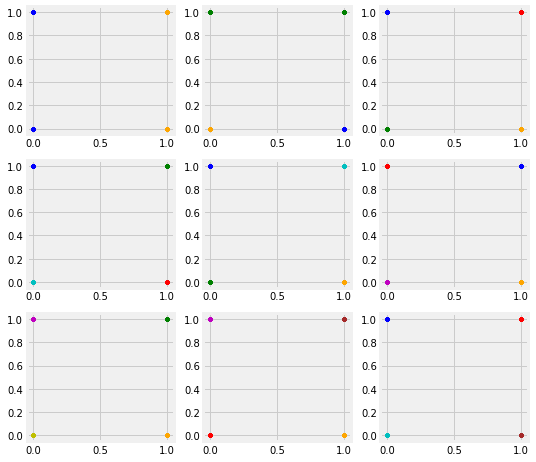

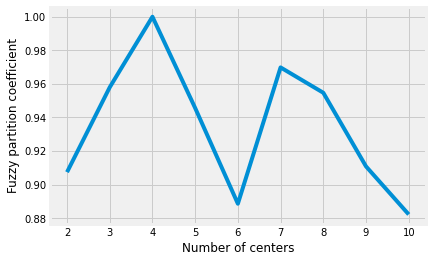

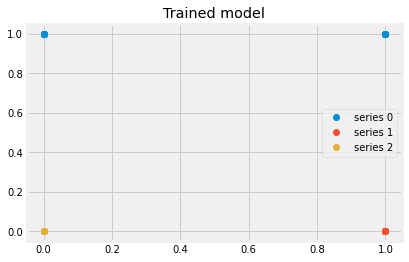

In [ ]:
#Youssef main block 
df= Twins1
df.dataframeName = 'data'

contfeats = [i for i in range(79) if i not in binfeat]
perm = binfeat + contfeats
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)
# mu_0 = df['mu0'].values
# mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

m=min(len(y_val),len(y_train))

# test=Fuzzy()
# new=test.fuzzify(df,[1,2],0,1)

test=Fuzzy()
new=test.fuzzify(df,[2,3],2,3)

In [ ]:
contfeats

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 58,
 68,
 78]

In [ ]:
#Youssef main block 
df= pd.read_csv('https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv', header = None)
df.dataframeName = 'data'
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df.columns = cols
df = pd.concat([df]*100, ignore_index=True)
#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(25) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

m=min(len(y_val),len(y_train))

test=Fuzzy()
new=test.fuzzify(df,[1,2],0,1)

   treatment  y_factual  y_cfactual    0    1  2  ...   73   74   75   76   77   78
0        0.0        0.0         0.0  1.0  1.0  1  ...  0.0  0.0  0.0  0.0  0.0  0.0
1        1.0        0.0         0.0  1.0  1.0  1  ...  0.0  0.0  0.0  0.0  0.0  0.0
2        0.0        0.0         0.0  1.0  1.0  1  ...  0.0  0.0  0.0  0.0  0.0  0.0
3        0.0        0.0         1.0  1.0  1.0  1  ...  1.0  0.0  0.0  0.0  0.0  0.0
4        0.0        0.0         0.0  1.0  1.0  1  ...  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 82 columns]


NameError: ignored

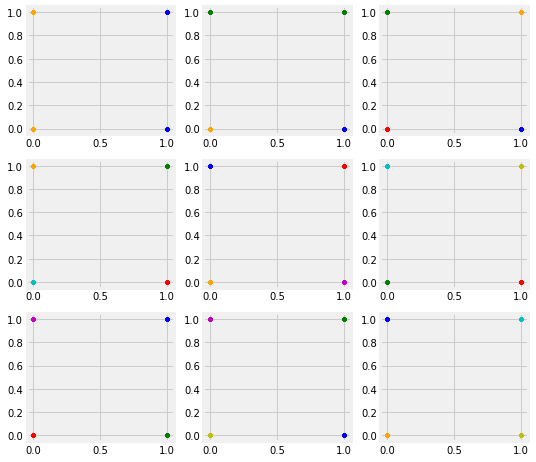

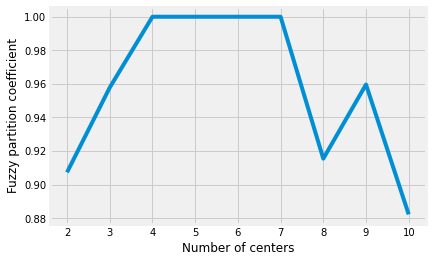

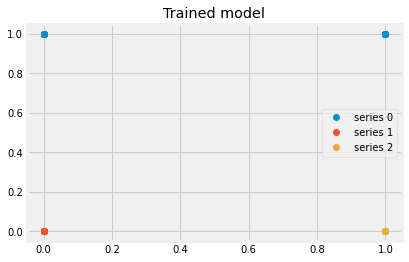

In [ ]:
df= Twins1
df.dataframeName = 'data'

cols =  ["treatment", "y_factual", "y_cfactual"] + [i for i in range(79)]

df.columns = cols
print(df.head())


#precising variables type
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
contfeats = [i for i in range(79) if i not in binfeats]
perm = binfeats + contfeats
df = df.reset_index(drop=True)
df.head()

X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)
# mu_0 = df['mu0'].values
# mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

m=min(len(y_val),len(y_train))

test=Fuzzy()
new=test.fuzzify(df,[1,2],0,1)

NameError: ignored

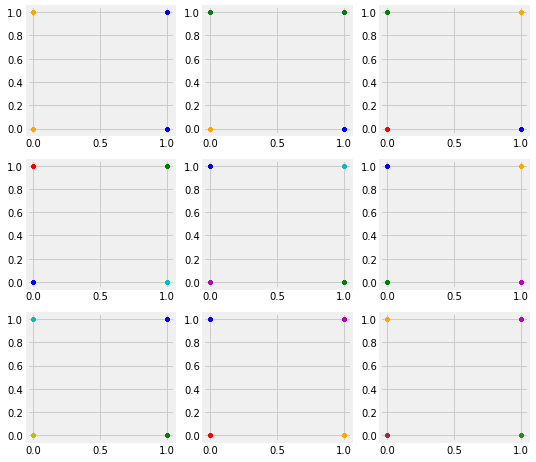

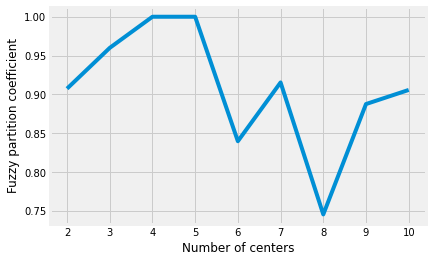

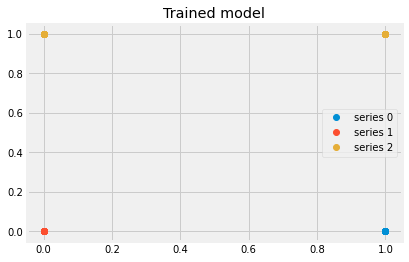

In [ ]:
binfeats = [6, 7, 8, 9, 10, 11]
contfeats = [i for i in range(1,79) if i not in binfeats]
perm = binfeats + contfeats
X = Twins1[perm].values
treatment = Twins1['treatment'].values
y = Twins1['y_factual'].values
y_cf = Twins1['y_cfactual'].values
tau = Twins1.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1 
               else y['y_cfactual'] - y['y_factual'], 
               axis=1)
# mu_0 = Twins['mu0'].values
# mu_1 = Twins['mu1'].values
# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

X_train, treatment_train, y_train, y_cf_train, tau_train= X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]
# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 300
num_epochs = 12
batch_size = 500
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers =2

test=Fuzzy()
new=test.fuzzify(Twins1,[2,3],2,3)

In [ ]:
contfeats

[0, 1, 2, 3, 4, 5]

# Colab codes snippes

In [ ]:
slider_value = 134 #@param {type:"slider", min:100, max:200, step:1}
print(slider_value)

134


In [ ]:
#@title Example form fields
#@markdown Forms support many types of fields.

no_type_checking = ''  #@param
string_type = 'example'  #@param {type: "string"}
slider_value = 200 #@param {type:"slider", min:100, max:200, step:1}
number = 102  #@param {type: "number"}
date = '2010-11-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}
#@markdown ---


In [ ]:
import ipywidgets as widgets

slider = widgets.IntSlider(20, min=0, max=100)
slider

IntSlider(value=20)

In [ ]:
#@title Default title text
import altair as alt
import ipywidgets as widgets
from vega_datasets import data

source = data.stocks()

stock_picker = widgets.SelectMultiple(
    options=source.symbol.unique(),
    value=list(source.symbol.unique()),
    description='Symbols')

# The value of symbols will come from the stock_picker.
@widgets.interact(symbols=stock_picker)
def render(symbols):
  selected = source[source.symbol.isin(list(symbols))]

  return alt.Chart(selected).mark_line().encode(
      x='date',
      y='price',
      color='symbol',
      strokeDash='symbol',
  )

interactive(children=(SelectMultiple(description='Symbols', index=(0, 1, 2, 3, 4), options=('MSFT', 'AMZN', 'I…

#Test

In [22]:
for i in range(79):
  if Twins1[i].max()==5:
    print(i)

1
5
7
12
35
41


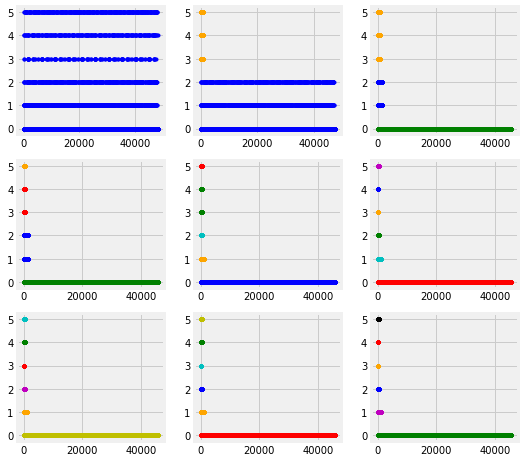

In [23]:
# Number of parent smoking per day fuzzification

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [4, 1, 5]
           

# Define three cluster sigmas in x and y, respectively
# sigmas = [[0.8, 0.3],
#           [0.3, 0.5],
#           [1.1, 0.8]]


xpts=Twins1[5].values
# ypts=Twins1[3].values

fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.transpose(xpts.reshape((xpts.shape[0], 1)))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    # for pt in cntr:
    #     ax.plot(pt[0], pt[1], 'rs')

#     ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
#     ax.axis('off')

# fig1.tight_layout()

cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# alldata = xpts

from scipy.spatial.distance import cdist
Test1=cdist(np.transpose(alldata), cntr, metric='euclidean')

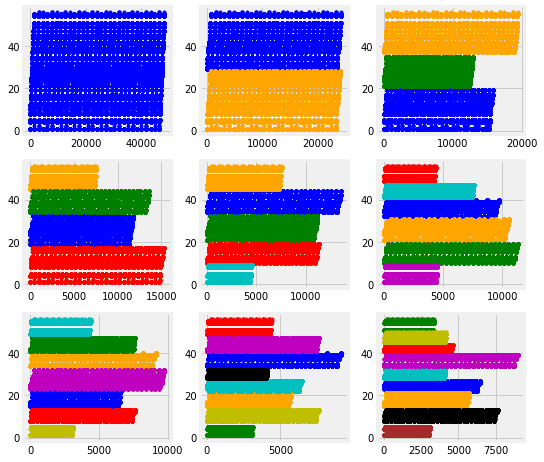

In [ ]:
# State of residence fuzzification

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [4, 1, 5]
           

# Define three cluster sigmas in x and y, respectively
# sigmas = [[0.8, 0.3],
#           [0.3, 0.5],
#           [1.1, 0.8]]


xpts=Twins1[3].values
# ypts=Twins1[3].values

fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.transpose(xpts.reshape((xpts.shape[0], 1)))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 1):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    # for pt in cntr:
    #     ax.plot(pt[0], pt[1], 'rs')

#     ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
#     ax.axis('off')

# fig1.tight_layout()

cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# alldata = xpts

from scipy.spatial.distance import cdist
Test2=cdist(np.transpose(alldata), cntr, metric='euclidean')

In [ ]:
# state of residence and  us census region fuzification
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.8]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

xpts=Twins1[2].values
ypts=Twins1[3].values

# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

alldata = np.vstack((xpts, ypts))

from scipy.spatial.distance import cdist
Test1=cdist(np.transpose(alldata), cntr, metric='euclidean')

In [24]:
#Fuzzy scale
def fuzzy_cluster_distance(array):
  return np.array([array[0]/array.sum(), array[1]/array.sum(), array[2]/array.sum()]) 

fuzzy_cluster_distance_stack0=np.apply_along_axis( fuzzy_cluster_distance, axis=1, arr=Test1 )
# fuzzy_cluster_distance_stack1=np.apply_along_axis( fuzzy_cluster_distance, axis=1, arr=Test2 )


In [25]:
Twins_temp0=Twins1.copy()
temp0=np.zeros(fuzzy_cluster_distance_stack0.shape)
for i in range(Twins_temp0.shape[0]):
  temp0[i]=Twins_temp0[5][i]*fuzzy_cluster_distance_stack0[i]

temp0T=np.transpose(temp0)
# temp1T=np.transpose(temp1)
temp0_low=temp0T[0]
temp0_medium=temp0T[1]
temp0_high=temp0T[2]

# temp1_low=temp1T[0]
# temp1_medium=temp1T[1]
# temp1_high=temp1T[2]  

Twins_temp1=Twins_temp0.copy()
Twins_temp1=Twins_temp1.drop([5], axis=1)
Twins_low=pd.concat([Twins_temp1, pd.Series(temp0_low)], axis=1)
Twins_medium=pd.concat([Twins_temp1, pd.Series(temp0_medium)], axis=1)
Twins_high=pd.concat([Twins_temp1, pd.Series(temp0_high)], axis=1)

cole1=[]
for i in range(79):
  cole1.append(i)
cols=['treatment',  'y_factual', 'y_cfactual']  
cols=cols+cole1


Twins_low.columns=cols
Twins_medium.columns=cols
Twins_high.columns=cols

#FCEVAE






In [ ]:
binfeat=[]
for i in range(79):
  if np.array(Twins_low[i]).max()==1 and np.array(Twins_low[i]).min()==0:
    binfeat.append(i)

binfeat


In [27]:
df= Twins_medium
df.dataframeName = 'data'

contfeats = [i for i in range(79) if i not in binfeat]
perm = binfeat + contfeats
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda y: y['y_factual'] - y['y_cfactual'] if y['treatment']==1
               else y['y_cfactual'] - y['y_factual'],
               axis=1)
# mu_0 = df['mu0'].values
# mu_1 = df['mu1'].values

# train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

m=min(len(y_val),len(y_train))

# test=Fuzzy()
# new=test.fuzzify(df,[1,2],0,1)

In [28]:
# model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 300
num_epochs = 15
batch_size = 500
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers =2

In [32]:
#Uber CEVAE handeler class
class CEVAE:
    def __init__(self, outcome_dist="studentt", latent_dim=20, hidden_dim=200, num_epochs=50, num_layers=3,
                 batch_size=100, learning_rate=1e-3, learning_rate_decay=0.1, num_samples=1000, weight_decay=1e-4):
        """
        Initializes CEVAE.
            Args:
                outcome_dist (str): Outcome distribution as one of: "bernoulli" , "exponential", "laplace", "normal",
                                    and "studentt"
                latent_dim (int) : Dimension of the latent variable
                hidden_dim (int) : Dimension of hidden layers of fully connected networks
                num_epochs (int): Number of training epochs
                num_layers (int): Number of hidden layers in fully connected networks
                batch_size (int): Batch size
                learning_rate (int): Learning rate
                learning_rate_decay (float/int): Learning rate decay over all epochs; the per-step decay rate will
                                                 depend on batch size and number of epochs such that the initial
                                                 learning rate will be learning_rate and the
                                                 final learning rate will be learning_rate * learning_rate_decay
                num_samples (int) : Number of samples to calculate ITE
                weight_decay (float) : Weight decay
        """
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        """
        Fits CEVAE.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(outcome_dist=self.outcome_dist,
                           feature_dim=X.shape[-1],
                           latent_dim=self.latent_dim,
                           hidden_dim=self.hidden_dim,
                           num_layers=self.num_layers)

        self.cevae.fit(x=torch.tensor(X, dtype=torch.float),
                       t=torch.tensor(treatment, dtype=torch.float),
                       y=torch.tensor(y, dtype=torch.float),
                       num_epochs=self.num_epochs,
                       batch_size=self.batch_size,
                       learning_rate=self.learning_rate,
                       learning_rate_decay=self.learning_rate_decay,
                       weight_decay=self.weight_decay)

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return self.cevae.ite(torch.tensor(X, dtype=torch.float),
                              num_samples=self.num_samples,
                              batch_size=self.batch_size).cpu().numpy()

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.
        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

# from  model import CEVAE

cevae_model = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

# fit
losses = cevae_model.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 78 minibatches per epoch
DEBUG 	 step     0 loss = 133.779
DEBUG 	 step   100 loss = 136.164
DEBUG 	 step   200 loss = 132.418
DEBUG 	 step   300 loss = 142.225
DEBUG 	 step   400 loss = 125.477
DEBUG 	 step   500 loss = 124.931
DEBUG 	 step   600 loss = 129.111
DEBUG 	 step   700 loss = 136.264
DEBUG 	 step   800 loss = 130.082
DEBUG 	 step   900 loss = 137.46
DEBUG 	 step  1000 loss = 129.192
DEBUG 	 step  1100 loss = 144.35


In [31]:
#train 
ite_train = cevae_model.predict(X_train)
ite_val = cevae_model.predict(X_val)

INFO 	 Evaluating 78 minibatches
DEBUG 	 batch ate = 0.0762116
DEBUG 	 batch ate = 0.0797602
DEBUG 	 batch ate = 0.0805551
DEBUG 	 batch ate = 0.0732569
DEBUG 	 batch ate = 0.0748325
DEBUG 	 batch ate = 0.0811401
DEBUG 	 batch ate = 0.07537
DEBUG 	 batch ate = 0.0755123
DEBUG 	 batch ate = 0.0787835
DEBUG 	 batch ate = 0.0788235
DEBUG 	 batch ate = 0.0762724
DEBUG 	 batch ate = 0.0849309
DEBUG 	 batch ate = 0.0770678
DEBUG 	 batch ate = 0.0779806
DEBUG 	 batch ate = 0.079653
DEBUG 	 batch ate = 0.0784049
DEBUG 	 batch ate = 0.0757778
DEBUG 	 batch ate = 0.0781206
DEBUG 	 batch ate = 0.0758715
DEBUG 	 batch ate = 0.0791249
DEBUG 	 batch ate = 0.0758653
DEBUG 	 batch ate = 0.0793325
DEBUG 	 batch ate = 0.0758761
DEBUG 	 batch ate = 0.0805289
DEBUG 	 batch ate = 0.0761763
DEBUG 	 batch ate = 0.0776545
DEBUG 	 batch ate = 0.0791032
DEBUG 	 batch ate = 0.0781923
DEBUG 	 batch ate = 0.0741226
DEBUG 	 batch ate = 0.0777227
DEBUG 	 batch ate = 0.0774512
DEBUG 	 batch ate = 0.0822748
DEBUG 	 ba

In [33]:
ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

0.078235984 0.07876378
